# Training a Linear Regression Neural Network


## Introduction

## Model of a Linear Regression Problem

For a typical linear regression problem we are given a training dataset $(\mathbf{X},\mathbf{y})$, where $\mathbf{X}$ is a matrix $n\times d$ and $\mathbf{y}$ is a vector of dimension $n\times 1$.

We assume that the data in $\mathbf{X}$ and $\mathbf{y}$ are linearly related in the following fashion:

$$
\mathbf{y}=\begin{pmatrix} y_{1} \\ y_{2} \\ \ldots \\ y_{n}\end{pmatrix}= \mathbf{X} \mathbf{w} + b\\
\begin{pmatrix}
x_{1}^{(1)} & x_{2}^{(1)} & \ldots & x_{d}^{(1)}\\
x_{1}^{(2)} & x_{2}^{(2)} & \ldots & x_{d}^{(2)}\\
\ldots\\
x_{1}^{(n)} & x_{1}^{(n)} & \ldots & x_{d}^{(n)}
\end{pmatrix}\cdot \begin{pmatrix} w_1 \\ w_2 \\ \ldots \\ w_{d}\end{pmatrix}+b\begin{pmatrix} 1 \\ 1 \\ \ldots \\ 1\end{pmatrix}. \tag{1}
$$

The task is to find the values of $\mathbf{w}$ and $b$ that make the equation (1) true.


Clearly, this may be impossible, so we settle by asking to find the values of $\mathbf{w},b$ that **minimizes** the error between $\mathbf{y}$(data given) and $$\mathbf{y}_{hat}=\mathbf{X} \mathbf{w} + b$$.

> We will find these values of $\mathbf{w},b$ by a process that we may call the _training of a neural network_.

## Key Ingredients to the Training of a Neural Network

Here are the key ingredients:
1. A neural model $\mathbf{M}(\mathbf{w},b)$ containing weights ($\mathbf{w}$) and bias ($b$).

1. A training data set ($(\mathbf{X},\mathbf{y})$).

   - From the training data, a collection of batch data is generated.

2. A loss function $L(\mathbf{w},b)$ that measures the error between the predicted data $\hat{\mathbf{y}}=\mathbf{X}\mathbf{w}+b$ and the label data $\mathbf{y}$.

3. The **Batch Stochastic Gradient Descent** is implemented. 

	- This process uses a batch of the data and then calculates the gradient (derivative) of the batch loss function with respect to the parameters $\mathbf{w},b$.

   - For this process the values of $\mathbf{w},b$ are updated by substracting an multiple of the gradient of the loss function. The multiple is the parameter $\eta$, the learning rate.


These ingredients are used in the fitting process for a neural network given a data set by going over the following steps:

- Generate/Obtain the training Data
- Define the Model
- Define the loss (fitting) function
- Define the Optimization process
- Train

> In this worksheet we will explore how to accomplish this process using **Pytorch**.

* We begin by importing the necessary libraries.

In [3]:
import matplotlib.pyplot as plt  #for plotting our graphs
%matplotlib inline
import random
import torch
from torch import nn
#The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers).
#from d2l import torch as d2l# the command from d2l import torch as d2l is used to import the torch module from the d2l package/module and refer to it as d2l in the rest of the code for brevity or convenience.


# Generating the Training Data

For this example, we will work in low dimension for succinctness.

- We want to generate 1,000 examples with 2-dimensional features drawn from a standard normal distribution. The resulting design matrix $\mathbf{X}$ belongs to $\mathbb{R}^{1000 \times 2}$.
- We generate each label by applying a _ground truth_ linear function, corrupting them via additive noise $\boldsymbol{\epsilon}$, drawn independently and identically for each example:

**$$\mathbf{y}= \mathbf{X} \mathbf{w}_1 + b_1 + \boldsymbol{\epsilon}.$$**

For convenience we assume that $\boldsymbol{\epsilon}$ is drawn
from a normal distribution with mean $\mu= 0$
and standard deviation $\sigma = 0.01$.

*  In this setup we will only make available to the linear regression neural network the values of $\mathbf{X}$ and $\mathbf{y}$, called the **training dataset**. 

* With this data, the network should generate the values of $\mathbf{w}_1,b_1$ after **training** with the data.

![image training](training.png)

Below, we set the true parameters to $\mathbf{w}_1=[2,−3.4]^⊤$ and $b_1=4.2$. Later, we can check our estimated parameters against these ground truth _1values.

In [4]:
#True parameters to be obtained after training
w1 = torch.tensor([2, -3.4])
b1 = 4.2

Recall that for this example, our training data set is made of $\mathbf{X},\mathbf{y}$ with

$$
\mathbf{X}=\begin{pmatrix}
x_1^{(1)} & x_2^{(1)} \\
x_1^{(2)} & x_2^{(2)} \\
\ldots\\
x_1^{(2,000)} & x_2^{(2,000)}
\end{pmatrix}
$$

and that the generated (synthetic data) values of $\mathbf{y}$ will be obtained as:

$$
\begin{pmatrix} y^{(1)}\\y^{(2)}\\ \ldots \\ y^{(2,000)}\end{pmatrix}=\mathbf{y}=\mathbf{X}\cdot \mathbf{w_1}^T+ b_1+ noise=\\
\begin{pmatrix}
x_1^{(1)} & x_2^{(1)} \\
x_1^{(2)} & x_2^{(2)} \\
\ldots & \ldots\\
x_1^{(2,000)} & x_2^{(2,000)}
\end{pmatrix}\cdot \begin{pmatrix} 2.0\\ -3.4 \end{pmatrix}+(4.2)\begin{pmatrix} 1 \\ 1\\ \ldots \\1 \end{pmatrix}+\begin{pmatrix} \epsilon_1 \\ \epsilon_2 \\ \ldots \\ \epsilon_{2000} \end{pmatrix}.
$$

We define the tensors $\mathbf{X}$ and $\mathbf{noise}$, and the result tensor $\mathbf{y}$ as follows.

In [5]:
n = 2000  #Size of X
standev = 0.01  #Standard deviation of the normal distribution centered at 0.
X = torch.randn(n, len(w1))  #Creates a random matrix X of size (n by len(w))
noise = torch.randn(n, 1) * standev  # creates a random matrix of size (n by 1)
y = torch.matmul(
    X, w1.reshape((-1, 1))) + b1 + noise  #w.reshape(-1,1) is w^T, the column vector version of the row vector w.

- Note that $b_1$ is a scalar, but in the last operation above, **Pytorch** incorporates it as a vector so that the addition in the code above works (broadcasting).

Let's have a look at the tensors in our definition

In [6]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)
print('Shape of w:', w1.shape)
print('Some particular values:X[0]=', X[0], '\ny[0]:', y[0],
      '\nnumber of training data:', n)

Shape of X: torch.Size([2000, 2])
Shape of y: torch.Size([2000, 1])
Shape of w: torch.Size([2])
Some particular values:X[0]= 

tensor([-1.1204, -0.1320]) 
y[0]: tensor([2.4201]) 
number of training data: 2000


> **REMARK** your (synthetic) data for this problem is the pair $(\mathbf{X},\mathbf{y})$. The vector $\mathbf{y}$ is made of the **labels**.

## Generating the batch data

Recall that for this training process, we will iteratively execute the _minibatch stochastic gradient descent_ algorithm to minimize our error.

- Recall also that this algorithm is based on taking a minibatch of the training data.

- The specific choice of the size of the said minibatch depends on many factors, such as the amount of memory, the number of accelerators, the choice of layers, and the total dataset size.

- Despite all that, a number between 32 and 256, preferably a multiple of a large power of $2$, is a good start.

- In its most basic form, in each iteration $t$, we first randomly sample a minibatch $\mathcal{B}_t$ consisting of a fixed number $|\mathcal{B}|$ of training examples.

- We then compute the derivative (gradient) of the average loss on the minibatch with respect to the model parameters.

- Finally, we multiply the gradient by a predetermined small positive value $\eta$, called the _learning rate_, and subtract the resulting term from the current parameter values.

- Recall that we expressed this updated process as:
  $$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


In summary, minibatch SGD proceeds as follows:

1. initialize the values of the model parameters, typically at random;
2. iteratively sample random minibatches from the data, updating the parameters in the direction of the negative gradient.

For quadratic losses and affine transformations,
this has a closed-form expansion:
$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}. \tag{eq\_linreg\_batch\_update}$$

After training for some predetermined number of iterations
(or until some other stopping criterion is met),
we record the estimated model parameters,
denoted $\hat{\mathbf{w}}, \hat{b}$.

### Implementing minibatches using Dataloader in Pytorch

We will use the class `DataLoader ` in the Pytorch module. See [here](https://www.educative.io/answers/what-is-pytorch-dataloader) for a detailed explanation of the use of that class.

The `DataLoader` class in **PyTorch** is a utility class that is used to load data in batches. It takes a dataset and a batch size as input, and it yields batches of data from the dataset.

Here is a brief overview of the `DataLoader` class:

_What is it?_

The `DataLoader` is an iterable that allows you to load data in batches from a **PyTorch** dataset.

_What does it do?_

The `DataLoader` does several things:

- It creates a sampler to iterate over the dataset.
- It splits the dataset into batches according to the batch size.
- It yields batches of data from the dataset.

_How does it work?_

- The `DataLoader` works by creating a sampler to iterate over the dataset. 
- The sampler can be a random sampler, a sequential sampler, or a custom sampler. 
- The sampler is used to select indices from the dataset. 
- The `DataLoader` then splits the dataset into batches according to the batch size. 
- Finally, the `DataLoader` yields batches of data from the dataset.



Why is it useful?

The `DataLoader` is useful for loading data in batches because it can improve the performance of training machine learning models. By loading data in batches, you can avoid loading the entire dataset into memory at once. This can save memory and improve the speed of training.

Here is an example of how to use the `DataLoader` class to load data from the `FashionMNIST` dataset:

<details>
  <summary><b>Example</b></summary>

```Python
import torch
from torchvision import datasets, transforms

### Load the FashionMNIST training dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True)

### Create a transform to convert the images to tensors
transform = transforms.ToTensor()

### Create a DataLoader object
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, transform=transform)

### Iterate over the DataLoader object and print the first batch of data
for batch in train_dataloader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break
```

</details>

In order to run the `DataLoader command`, we need to have defined a training dataset, a batch size and, if necessaty the type of transform because the `DataLoader `object is of type tensor.

The code below defines the required parameter and the `Dataloader` variable.

The `TensorDataset` class takes a list of tensors as input, and it stores the tensors in a dataset.

In [7]:
# we first generate a TensorDataset variable for the input data
#X,y presented as a list.
dataset = torch.utils.data.TensorDataset(X, y)
# now we create the iterator that will extract batches from
# the data
batch_size = 32  # we define the batch size
#The call below pases the data set, the batch size and request that the batches are shuffled randomly from the whole dataset.
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
#once we create the variable dataloader,we can iterated over
#all of the batches.
print("number of batches in dataloader:", len(dataloader))
#Note that number of batches in dataloader * batch size is approximately equal
# to the number of items in the data set.
#Below is an example of a typical batch
newbatchX, newbatchy = next(
    iter(dataloader)
)  # call tensorloader function to select a batch of the trainig dataset X and y
print('newbatchX shape:', newbatchX.shape, '\nnewbatchy shape:',
      newbatchy.shape)
print("Length of batch:", len(newbatchy))
print("first value of X:", newbatchX[0])
print("first value of y_hat:", newbatchy[0])
#we get the next batch
newbatchX, newbatchy = next(iter(dataloader))  # call tensorloader function
print('newbatchX shape:', newbatchX.shape, '\nnewbatchy shape:',
      newbatchy.shape)
print("first value of batch X:", newbatchX[0])
print("first value of batch y_yhat:", newbatchy[0])

number of batches in dataloader: 63
newbatchX shape: torch.Size([32, 2]) 
newbatchy shape: torch.Size([32, 1])
Length of batch: 32
first value of X: tensor([-1.1751,  0.9408])
first value of y_hat: tensor([-1.3597])
newbatchX shape: torch.Size([32, 2]) 
newbatchy shape: torch.Size([32, 1])
first value of batch X: tensor([0.5019, 0.6739])
first value of batch y_yhat: tensor([2.9259])


> Now that we have the batch of the training data set generated, we move to te second step: define our neural network in **Pytorch**.

# Defining the Neural Network

Once we defined the data that will be used to train the neural network, and how we will access that data, we must defined the model to be working with, i.e. the neural network that we will be using.

For this case, the neural network to be defined is particular class of the neural networks in **Pytorch**.

> Our class for this example will be a `LazyLinear` class.

- This class allows users to specify merely the output dimension, there is no need to additionally asks for how many inputs go into this layer.

- Specifying input shapes is inconvenient and may require nontrivial calculations (such as in convolutional layers). Thus, for simplicity, we will use such "lazy" layers whenever we can.


This neural network is made of a set of weights $\hat{\mathbf{w}}$ and a constant $\hat{b}$ such that for any input data $X^\prime$,

$$
X^\prime=\begin{pmatrix}
x_{0} & x_{1}
\end{pmatrix}
$$

the output of the neural network is going to be scalar $\hat{y}$:

$$
\tag{1}
\hat{y}=X^\prime\cdot \hat{\mathbf{w}}^T+ \hat{b}=\\
\begin{pmatrix}
x_{0} & x_{1}
\end{pmatrix}\cdot \begin{pmatrix} \hat{\mathbf{w}_1}\\ \hat{\mathbf{w}_2 }\end{pmatrix}+\hat{b}
$$

> The following code defines our linear model in **Pytorch**. Note that despite the model being  defined the random values of the parameters have not been assigned yet.

In [8]:
#we define a linear neural network. We do not need to define the size of the input yet. This neural network will have one layer.
LinearModel = nn.LazyLinear(1)  #This layer will have output dimension 1
LinearModel.weight.data.normal_(
    0, 0.01)  #(We initialize the parameters (weights) of the neural network
#randomly, from a normal distribution with mean 0 and standard deviation 0.01.
LinearModel.bias.data.fill_(
    0)  # We initialize the array of b (the bias) with zeros.
# We can see the values of the parameters w and b of this neural network
#by using the method parameters() as shown below
parameters = LinearModel.parameters()
# Print the parameters of the neural network
for parameter in parameters:
    print(parameter
          )  # Note that at this point the parameters have not been initialized

<UninitializedParameter>
<UninitializedParameter>


# How to Calculate the Outputs of the Linear Neural Network (_forward pass_)?

Given any input $X^\prime$, the neural network `LinearModel` calculates the output given by the equation (1) above.

> **OBSERVATION** In **Pytorch**, neural networks have a particular behavior depending if you are **evaluating it** or **training it**.



- **Training mode** is the **default** mode for neural network models. In training mode, the model is constantly learning and updating its weights and biases.

  - This is done using a process called **backpropagation**, which is a method for computing the gradient of the loss function with respect to the weights and biases of the model.

- **Evaluation mode** is used when you want to evaluate the performance of a trained model on a test dataset.

	- In evaluation mode, the model will not updated its weights and biases. This is because the model has already been trained, and there is no need to continue training it.

<div class="alert alert-block alert-warning">
<b>WARNING!</b> In the PyTorch nn package, the `.eval()` method is used to switch a neural network model from training mode to evaluation mode. This means that the model will no longer perform certain operations that are specifically for training, such as dropout and batch normalization.
    The `train()` method is used to switch a neural network model from evaluation mode to training mode.
</div>
Below we can see an example of the behavior of the neural network in the evaluation mode.

In [9]:
LinearModel.eval()  # We make sure that the neural network is in evaluation mode
print(
    "We evaluate now the output of the neural network for an input of [1.0,0.0]"
)
#input of the  neural network
input = torch.tensor([[1.0, 0.0],[1.0, 1.0]])
#here is how we calculate the output: w_1*x_1+w_2*x_0+b=w_1+b
output = LinearModel(input)
print("Output is=", output)  #Note that the output of the neural network is as
# expected w_1+b
#Now we check the parameters of the neural network
parameters = LinearModel.parameters()
# Print the parameters of the neural network
for parameter in parameters:
    print(parameter)  #Prints w and b

We evaluate now the output of the neural network for an input of [1.0,0.0]
Output is= tensor([[-0.0030],
        [-0.1939]], grad_fn=<AddmmBackward0>)
Parameter containing:
tensor([[ 0.3150, -0.1909]], requires_grad=True)
Parameter containing:
tensor([-0.3179], requires_grad=True)


# The Loss Function

In order to optimize the weights of the neural network, we need to iterate a procedure (the gradient method) that updates the values of the weights and bias in such a way that ot minimizes the error, or loss.

The **loss function** is calculated by looking at the aggregated difference between the given data ($\mathbf{y}$) and the corresponding generated data $\hat{\mathbf{y}}$, for a given data input $X^\prime$.

We calculate this error using a predefined error function in **Pytorch**.

- The `MSELoss` class computes the mean squared error (without the $1/2$ factor in :eqref:`eq_mse`).
- By default, `MSELoss` returns the average loss over examples.

It is faster (and easier to use) than implementing our own.

We will use this in our definition of the loss function.

In [10]:
def loss(y_hat, y):  # Define function loss
    fn = nn.MSELoss()
    return fn(y_hat, y)


# Here is an example of the calculation of the average loss over a batch
y2 = torch.tensor([[1.0], [1.0], [1.0]])  # 3 labels in this made up batch
y2_hat = torch.tensor([[0.5], [0.5], [0.5]
                       ])  #3 corresponding calculated values for the batch
print("loss for batch is:", loss(y2_hat, y2))

loss for batch is: tensor(0.2500)


# Defining The Optimizer

Now we need to define the optimizing process for the loss function of the neural network.

> As discussed before, all of these methods are based on the _gradient descent_ idea.

- In this particular example, the optimization process will iterate over the values of the parameters of the neural network `LinearModel`.

- **PyTorch** provides several optimization methods for adjusting the parameters of a neural network during training.

- These methods differ in their algorithms and characteristics, making them suitable for different types of models and datasets. Here's an overview of some common optimization methods in torch.optim:


- **Stochastic Gradient Descent (SGD)**: `SGD` is a widely used optimization method that updates the parameters of the neural network in the direction of the steepest descent of the loss function. It's computationally efficient and works well for simple models and datasets.

- **Momentum** `Momentum` is an extension of `SGD` that adds a momentum term to the weight updates. This helps to smooth out the updates and accelerate convergence, especially in cases where the loss function has a complex landscape.

- **Nesterov Accelerated Gradient Descent (NAG)**: `NAG` is another variant of `SGD` that uses a different momentum scheme to further improve convergence. It often performs better than `SGD` and momentum on convex problems.

- **AdaGrad**: `AdaGrad` is an adaptive learning rate optimizer that adjusts the learning rate for each parameter based on its past gradients. This can help to prevent oscillations and improve convergence for problems with highly variable gradients.

- **RMSProp**: `RMSProp` is another adaptive learning rate optimizer that uses a moving average of the squared gradients to adjust the learning rate. It's similar to `AdaGrad` but often performs better in practice.

- **Adam**: `Adam` is a popular optimization method that combines the adaptive learning rate approach of `AdaGrad` and `RMSProp` with `momentum`. It's generally more stable and faster than `SGD` and can work well for a wide range of models and datasets.



The choice of optimization method depends on several factors, including the complexity of the model, the characteristics of the dataset, and the desired performance.

It's often beneficial to experiment with different optimization methods to find the one that works best for a specific problem.

For this example we select SGD.

<details>
  <summary><b>Detailed Explanation of the SGD code</b></summary>

Stochastic Gradient Descent (SGD) is an optimization algorithm commonly used in machine learning to minimize an objective function, especially for large datasets. It's a simplified version of gradient descent that updates the parameters of a neural network in the direction of the steepest descent of the loss function, but instead of using the entire dataset, it uses a small batch of data at each iteration.

Algorithm:

Initialize the parameters of the neural network: Set the initial values for the weights and biases of the neural network.

Iterate over the training data: For each training example, do the following:

a. Compute the predicted output: Pass the training example through the neural network to obtain the predicted output.

b. Compute the loss: Compute the loss between the predicted output and the target output.

c. Compute the gradient: Compute the gradient of the loss function with respect to the parameters of the neural network.

d. Update the parameters: Update the parameters of the neural network using the gradient and a learning rate.

</details>

Here is how we define the optimizer for the linear network.

In [11]:
#We select to optimize the loss function using the SGD method
# lr is the learning rate. This is the amount by which you multiply each one of the partial derivatives of the gradient to substract from the parameters values.
#We use the command optim.GEd to optimize the parameters of the linear model.
LinearOptimizer = torch.optim.SGD(LinearModel.parameters(), lr=0.01)

# Training the Neural Network

The final step is to **train** our neural network. To do this, we must define first the total number of iterations (**epochs**) to be performed.

For every **epoch**, we iterate over all the training data in batches:

- For each training batch, we compute the predicted output of the neural network using the forward pass.

- Then, compute the loss between the predicted output and the target output.

- Then, update the parameters of the neural network using the backward pass and the optimizer.

**NOTE** Up to this points we have the following items for our model:

---
1. **Data**: The data info `X`, `y` transformed into the `dataloader` iterator that generates our batches.
2. **The linear model** `LinearModel` defined above
3. The **loss function** `loss` defined above
4. The **linear optimizer** `LinearOptimizer` which we selected to be `SGD`.
5. the **learning rate** `lr=0.01`
6. The number of **epochs**, `epochs` which the total number of times that we will iterate over all the data on the batches is 5.

---

Comments on the code below:

`LinearOptimizer.zero_grad()`: This line sets the gradients of all parameters in the optimizer to zero. This is necessary because the gradients accumulate over time, and if they are not reset before each training step, the updates will be based on the gradients from all previous steps, which can lead to unstable training.

`Loss.backward()`: This line computes the gradient of the loss function with respect to the parameters of the model. This is done using a technique called backpropagation, which recursively computes the derivatives of the loss function with respect to all of the parameters in the model.

`LinearOptimizer.step()`: This line updates the parameters of the model based on the gradients that were computed in the previous step. The optimizer uses a specific algorithm to update the parameters, such as stochastic gradient descent (SGD) or Adam. The algorithm takes into account the learning rate, which controls the size of the updates, and any other parameters that are specific to the optimizer.

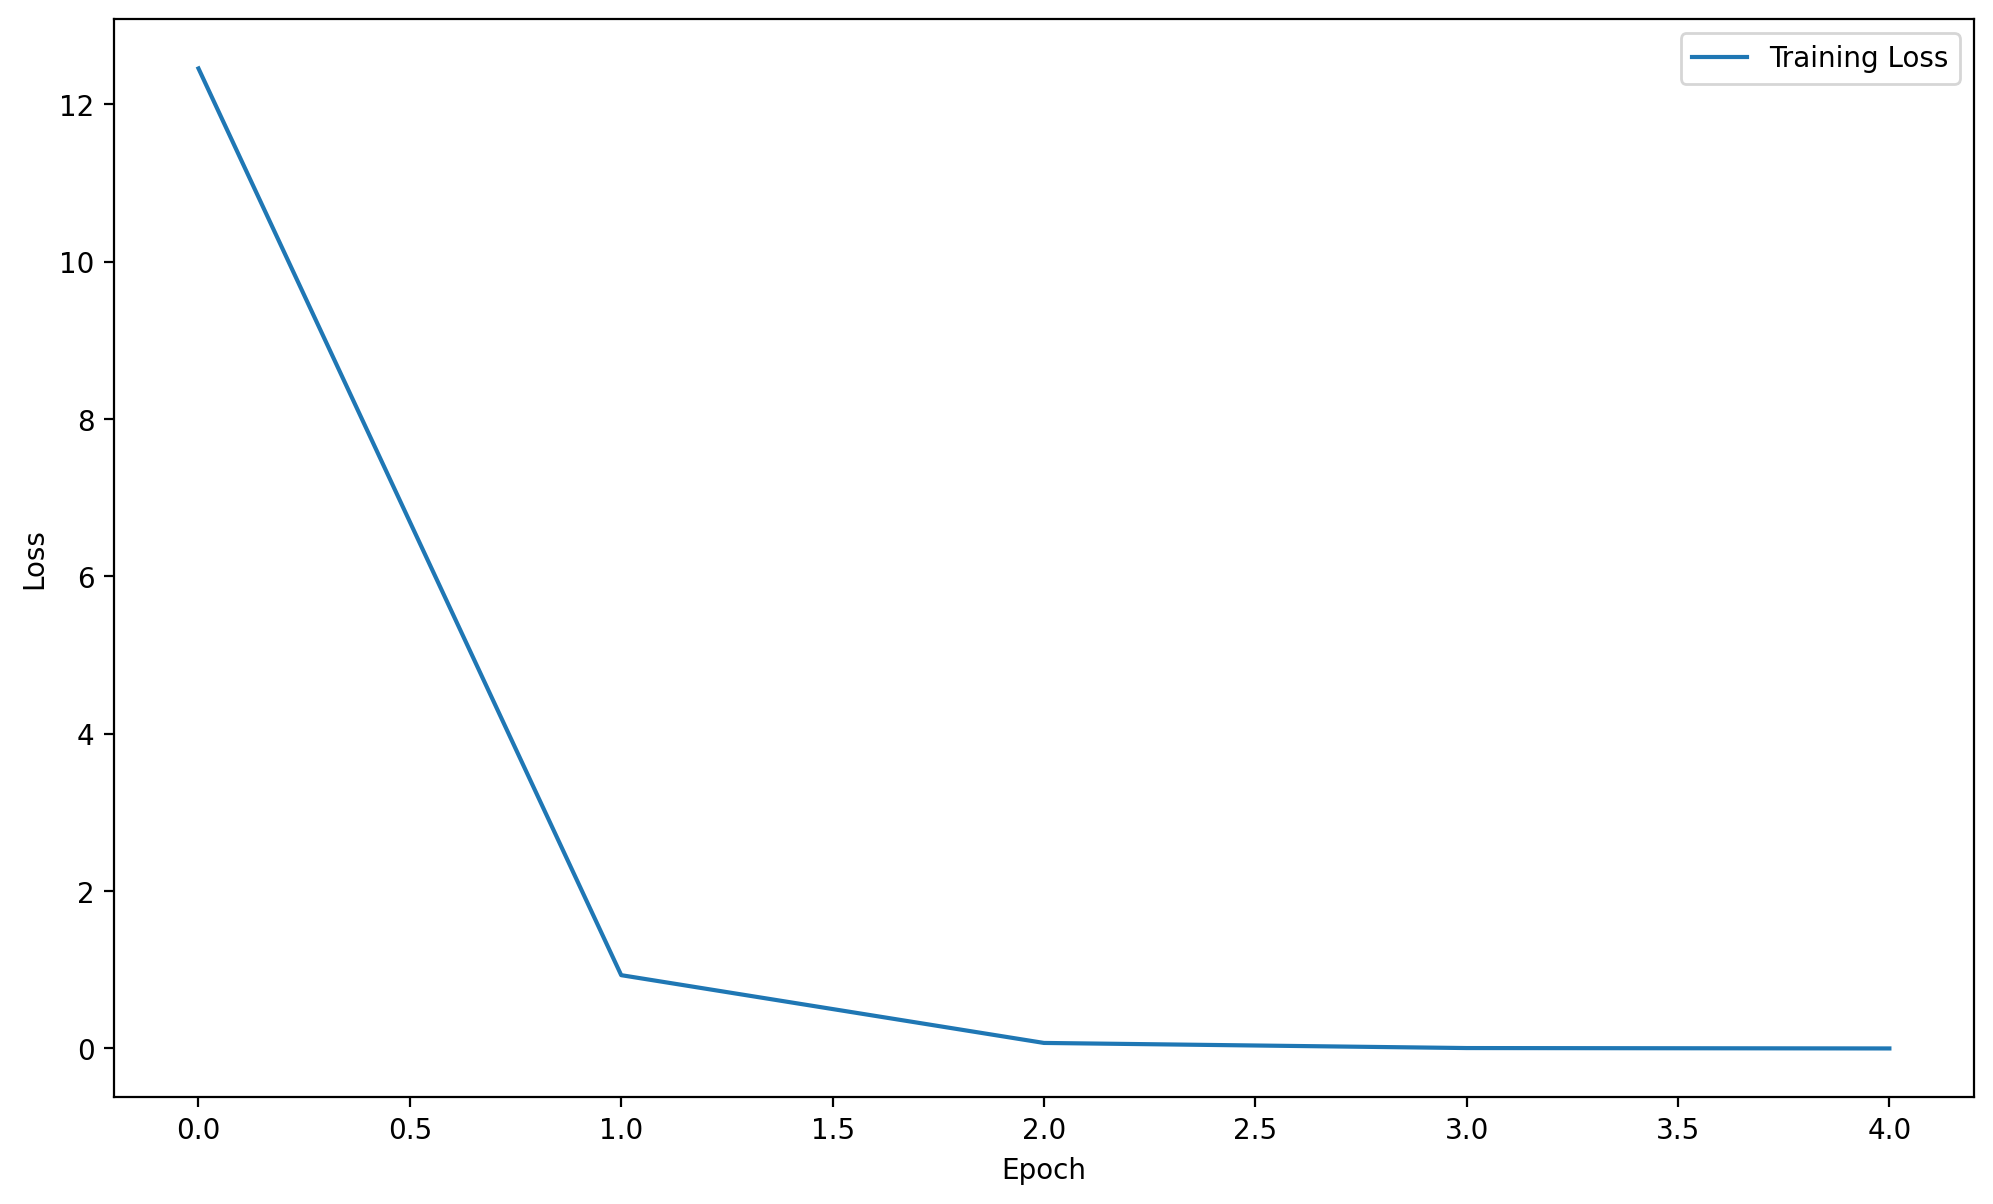

Final Values of parameters of the linear neural network
Parameter containing:
tensor([[ 1.9983, -3.3951]], requires_grad=True)
Parameter containing:
tensor([4.1925], requires_grad=True)
target value of w: tensor([ 2.0000, -3.4000]) target value of b: 4.2


In [12]:
# Set the model to training mode!
LinearModel.train()
# Initialize a list to store the loss values for each epoch
total_loss = []
#we define the max number of epochs:
max_epochs = 5
#We loop over each epoch
for epoch in range(max_epochs):  # Adjust number of epochs as needed
    #initialize loss_value to 0
    loss_value = 0.0
    #for every epoch we iterate over all the batches in dataloader
    for batch_idx, (batchX, batchy) in enumerate(dataloader):
        LinearOptimizer.zero_grad()  # Clear gradients before each batch
        #Forward pass
        y_hat = LinearModel(batchX)
        # Calculate loss
        lossbatch = loss(y_hat, batchy)
        # Backward pass and update weights
        lossbatch.backward()
        LinearOptimizer.step()
        #Add to loss_value the value of lossbatch
        loss_value = loss_value + lossbatch
        #End Loop
    # We calculate now the average loss for the epoch
    epoch_loss = loss_value.item() / len(dataloader)
    #we append the average loss to the list of epoch losses
    total_loss.append(epoch_loss)
    #End of Epoch
# we plot now the graph of total_loss values against the epochs.
plt.plot(total_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# finally, we print the optimized parameters of the linear neural network and compare them with the target parameters.
parameters = LinearModel.parameters()
# Print the parameters of the neural network
print("Final Values of parameters of the linear neural network")
for parameter in parameters:
    print(parameter)
print("target value of w:", w1, "target value of b:", b1)

**QUESTION 0** What would happen if we were to initialize the weights of the model to zero instead of randomly?. Would the training algorithm still work? Write some code that implements this initial set of values of w being zero.

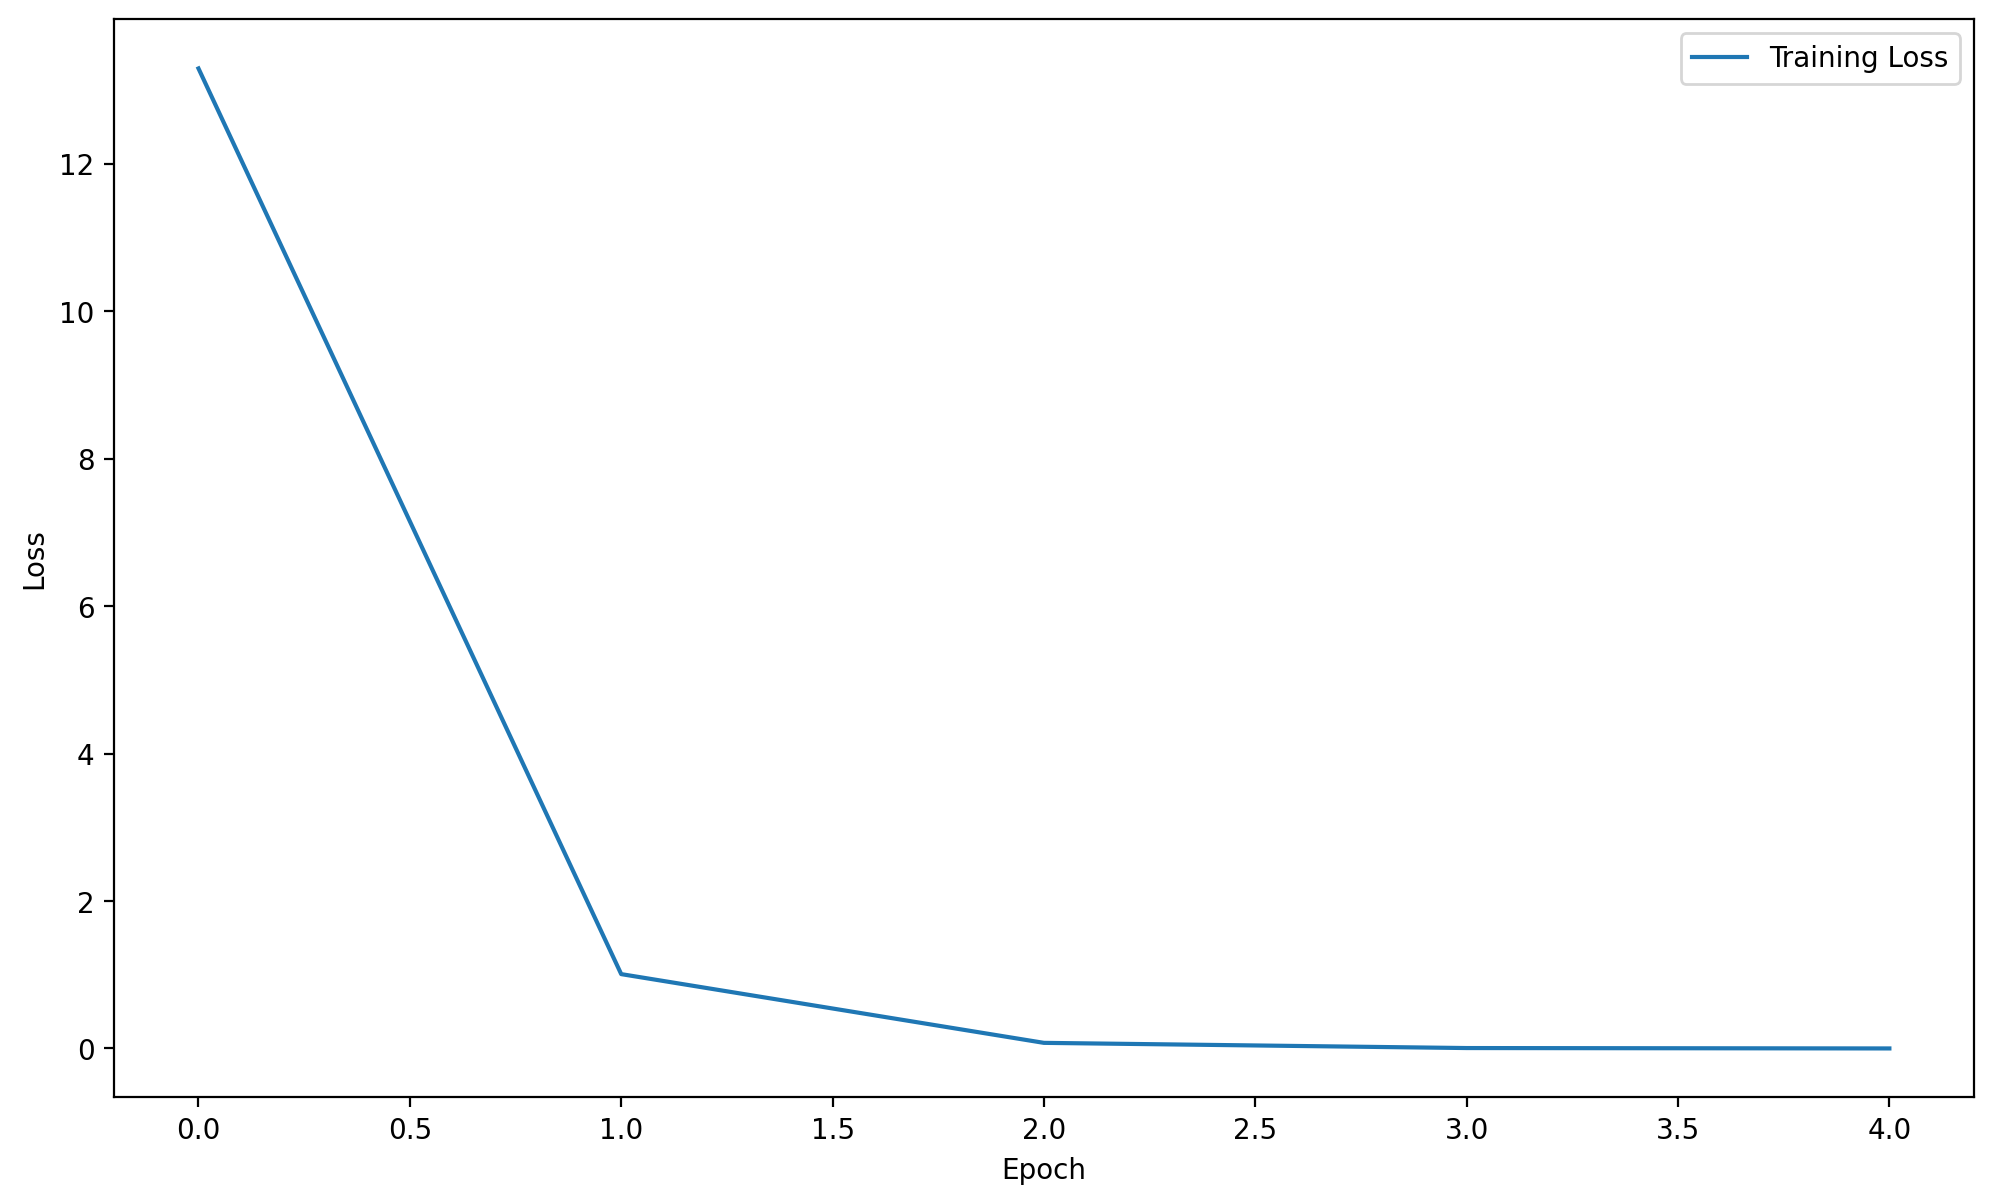

Final Values of parameters of the linear neural network
Parameter containing:
tensor([[ 1.9987, -3.3937]], requires_grad=True)
Parameter containing:
tensor([4.1928], requires_grad=True)
target value of w: tensor([ 2.0000, -3.4000]) target value of b: 4.2


In [13]:
# Write your code here


#we define a linear neural network. We do not need to define the size of the input yet. This neural network will have one layer.
LinearModel1 = nn.LazyLinear(1)  #This layer will have output dimension 1
LinearModel1.weight.data.fill_(0)  #(We initialize the parameters (weights) of the neural network
LinearModel1.bias.data.fill_(0)  # We initialize the array of b (the bias) with zeros.

    
LinearOptimizer1 = torch.optim.SGD(LinearModel1.parameters(), lr=0.01)
    
# Initialize a list to store the loss values for each epoch
total_loss1 = []
#we define the max number of epochs:
max_epochs = 5
#We loop over each epoch
for epoch in range(max_epochs):  # Adjust number of epochs as needed
    #initialize loss_value to 0
    loss_value = 0.0
    #for every epoch we iterate over all the batches in dataloader
    for batch_idx, (batchX, batchy) in enumerate(dataloader):
        LinearOptimizer1.zero_grad()  # Clear gradients before each batch
        #Forward pass
        y_hat = LinearModel1(batchX)
        # Calculate loss
        lossbatch = loss(y_hat, batchy)
        # Backward pass and update weights
        lossbatch.backward()
        LinearOptimizer1.step()
        #Add to loss_value the value of lossbatch
        loss_value = loss_value + lossbatch
        #End Loop
    # We calculate now the average loss for the epoch
    epoch_loss = loss_value.item() / len(dataloader)
    #we append the average loss to the list of epoch losses
    total_loss1.append(epoch_loss)
    #End of Epoch
# we plot now the graph of total_loss values against the epochs.
plt.plot(total_loss1, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# finally, we print the optimized parameters of the linear neural network and compare them with the target parameters.
parameters = LinearModel1.parameters()
# Print the parameters of the neural network
print("Final Values of parameters of the linear neural network")
for parameter in parameters:
    print(parameter)
print("target value of w:", w1, "target value of b:", b1)

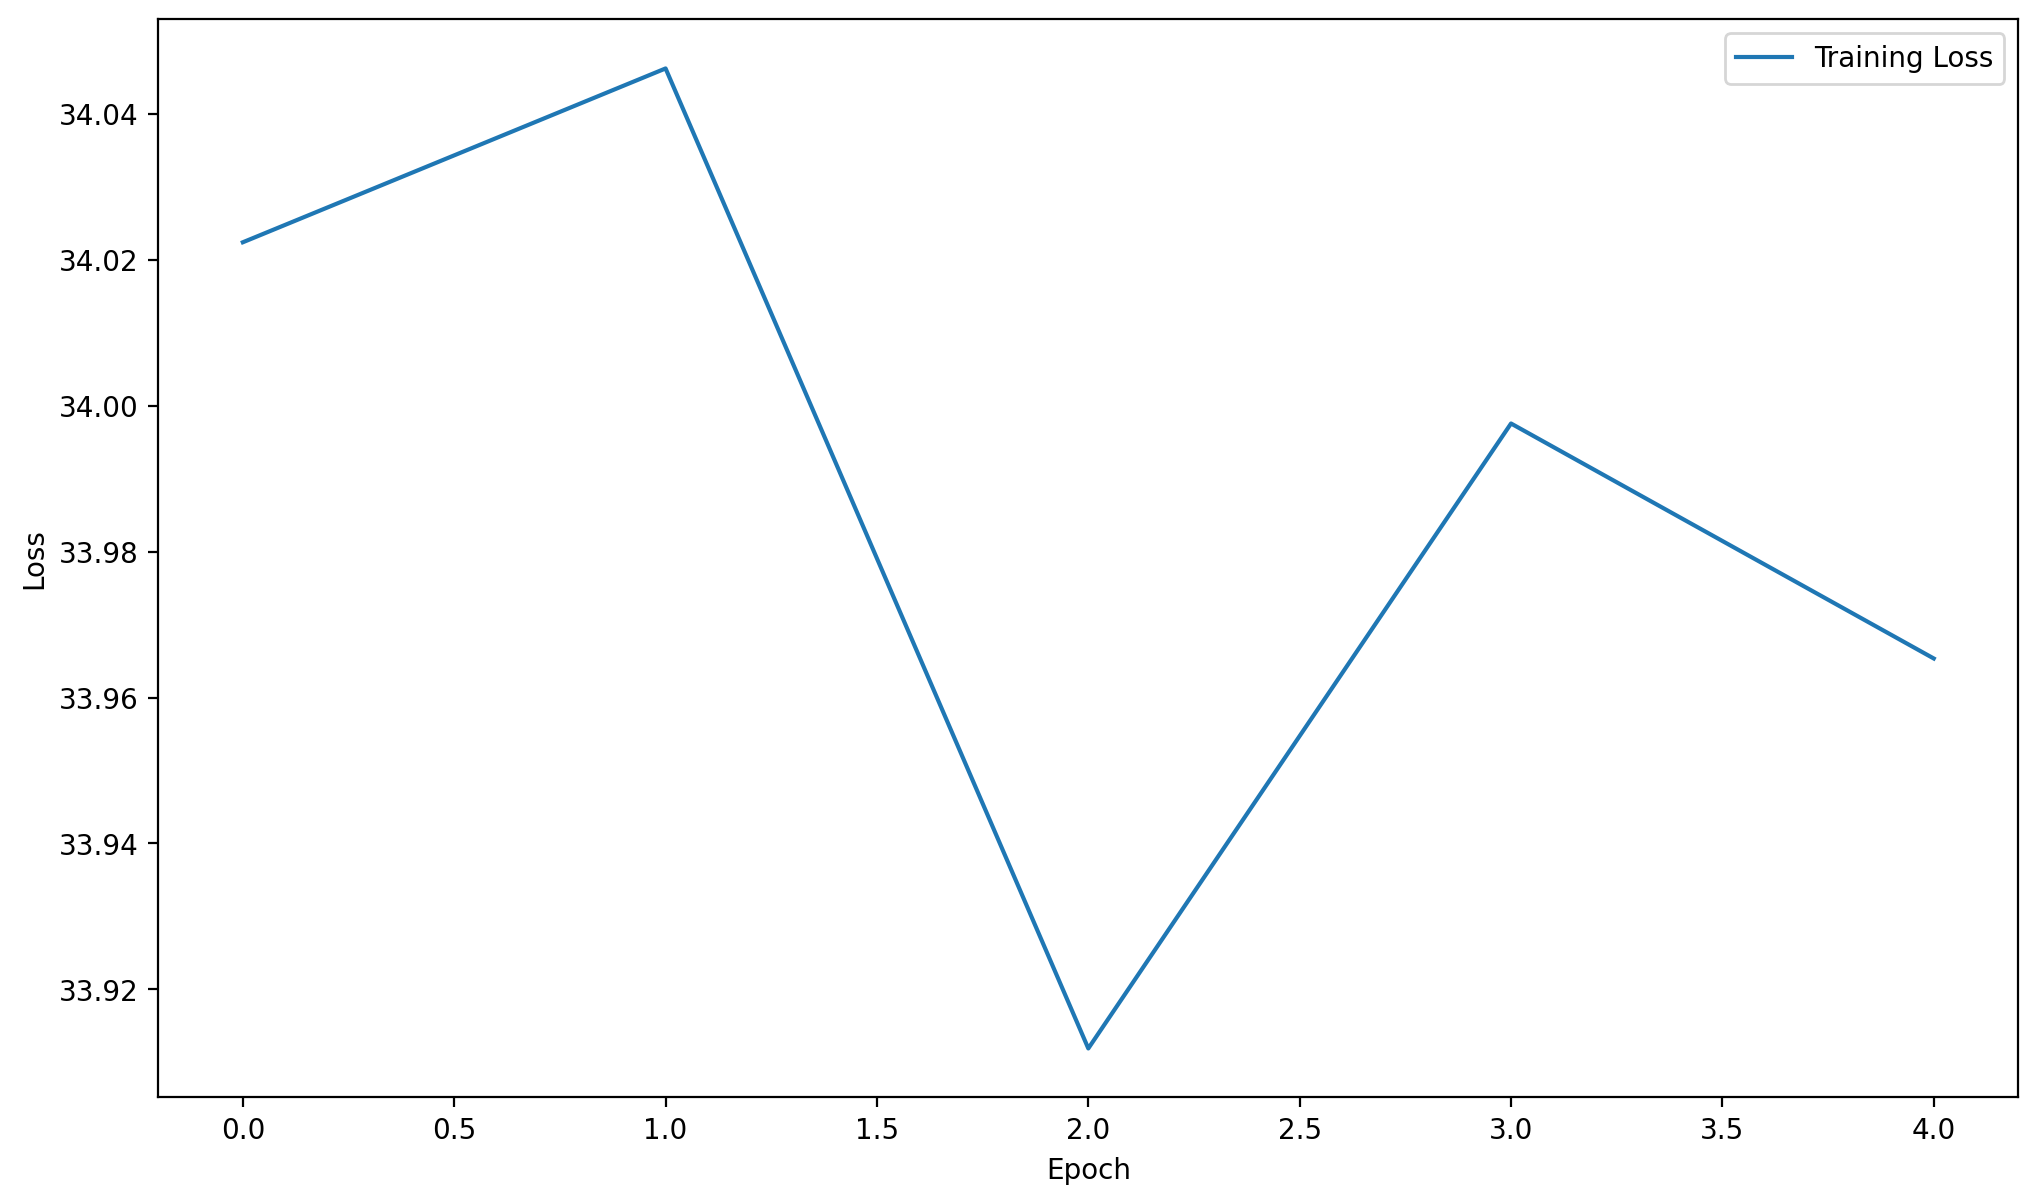

Final Values of parameters of the linear neural network
Parameter containing:
tensor([[ 0.6955, -0.4565]], requires_grad=True)
Parameter containing:
tensor([-0.6165], requires_grad=True)
target value of w: tensor([ 2.0000, -3.4000]) target value of b: 4.2


In [14]:
# Write your code here


#we define a linear neural network. We do not need to define the size of the input yet. This neural network will have one layer.
LinearModel2 = nn.LazyLinear(1)  #This layer will have output dimension 1
LinearModel2.weight.data.fill_(100)  #(We initialize the parameters (weights) of the neural network
LinearModel2.bias.data.fill_(0)  # We initialize the array of b (the bias) with zeros.

    
LinearOptimizer2 = torch.optim.SGD(LinearModel1.parameters(), lr=0.01)
    
# Initialize a list to store the loss values for each epoch
total_loss2 = []
#we define the max number of epochs:
max_epochs = 5
#We loop over each epoch
for epoch in range(max_epochs):  # Adjust number of epochs as needed
    #initialize loss_value to 0
    loss_value = 0.0
    #for every epoch we iterate over all the batches in dataloader
    for batch_idx, (batchX, batchy) in enumerate(dataloader):
        LinearOptimizer2.zero_grad()  # Clear gradients before each batch
        #Forward pass
        y_hat = LinearModel2(batchX)
        # Calculate loss
        lossbatch = loss(y_hat, batchy)
        # Backward pass and update weights
        lossbatch.backward()
        LinearOptimizer2.step()
        #Add to loss_value the value of lossbatch
        loss_value = loss_value + lossbatch
        #End Loop
    # We calculate now the average loss for the epoch
    epoch_loss = loss_value.item() / len(dataloader)
    #we append the average loss to the list of epoch losses
    total_loss2.append(epoch_loss)
    #End of Epoch
# we plot now the graph of total_loss values against the epochs.
plt.plot(total_loss2, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# finally, we print the optimized parameters of the linear neural network and compare them with the target parameters.
parameters = LinearModel2.parameters()
# Print the parameters of the neural network
print("Final Values of parameters of the linear neural network")
for parameter in parameters:
    print(parameter)
print("target value of w:", w1, "target value of b:", b1)

**QUESTION 0.0**

What will happen if we changed the learning rate? Please run some experiments with this training to see the effects of modifying the learning rate `lr`.


In [15]:
LinearOptimizer3.zero_grad()


#we define a linear neural network. We do not need to define the size of the input yet. This neural network will have one layer.
LinearModel3 = nn.LazyLinear(1)  #This layer will have output dimension 1
LinearModel3.weight.data.normal_(0,0.1)  #(We initialize the parameters (weights) of the neural network
LinearModel3.bias.data.fill_(0)  # We initialize the array of b (the bias) with zeros.

    
LinearOptimizer3 = torch.optim.SGD(LinearModel3.parameters(), lr=1)
    
# Initialize a list to store the loss values for each epoch
total_loss3 = []
#we define the max number of epochs:
max_epochs = 40
#We loop over each epoch
for epoch in range(max_epochs):  # Adjust number of epochs as needed
    #initialize loss_value to 0
    loss_value = 0.0
    #for every epoch we iterate over all the batches in dataloader
    for batch_idx, (batchX, batchy) in enumerate(dataloader):
        LinearOptimizer3.zero_grad()  # Clear gradients before each batch
        #Forward pass
        y_hat = LinearModel3(batchX)
        # Calculate loss
        lossbatch = loss(y_hat, batchy)
        # Backward pass and update weights
        lossbatch.backward()
        LinearOptimizer3.step()
        #Add to loss_value the value of lossbatch
        loss_value = loss_value + lossbatch
        #End Loop
    # We calculate now the average loss for the epoch
    epoch_loss = loss_value.item() / len(dataloader)
    #we append the average loss to the list of epoch losses
    total_loss3.append(epoch_loss)
    #End of Epoch
# we plot now the graph of total_loss values against the epochs.
plt.plot(total_loss3, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# finally, we print the optimized parameters of the linear neural network and compare them with the target parameters.
parameters = LinearModel3.parameters()
# Print the parameters of the neural network
print("Final Values of parameters of the linear neural network")
for parameter in parameters:
    print(parameter)
print("target value of w:", w1, "target value of b:", b1)



NameError: name 'LinearOptimizer3' is not defined

## Object Oriented Programming Approach to Linear Regression

- Our code for the Linear Regression optimization is an easy one.

- We can take this opportunity to create the same code using OOD.

We will create the following classes:

| Class Name | Purpose|
| -------- | ------- |
| `LinerRegressionDataset` | Data Generation |
| `LinearRegressionModel` | Linear Model |
| `MSELossWrapper` | Loss Function |
| `SGDOptimizer` | Optimizer |

### Data Generation

for our synthetic data generation, we will create a class named `LinearRegressionDataset` that inherits from `torch.utils.data.Dataset` to handle data generation and hold the true parameters (`w1` and `b1`).

[Here](https://pytorch.org/docs/stable/data.html) is some basic information on the class `torch.utils.data.Dataset`.

Please take a look at the code defining this class.

In [16]:
import torch

class LinearRegressionDataset(torch.utils.data.Dataset):
    """
  Custom Dataset class for generating linear regression data.

  This class inherits from `torch.utils.data.Dataset` and provides methods
  to generate data points for training a linear regression model.
  """

    def __init__(self, n, w1, b1, standev=0.01):
        """
    Initializes the dataset with the following parameters:

    - n (int): Number of data points to generate.
    - w1 (torch.Tensor): True weight vector for the linear model.
    - b1 (float): True bias term for the linear model.
    - standev (float, optional): Standard deviation of the noise added 
                                  to the data (default: 0.01).
    """
        self.n = n
        self.w1 = w1
        self.b1 = b1
        self.standev = standev

    def __len__(self):
        """
    Returns the total number of data points in the dataset.
    """
        return self.n

    def __getitem__(self, idx):
        """
    Returns a single data point (X, y) at the specified index.

    - idx (int): Index of the data point to be retrieved.

    Returns:
      - X (torch.Tensor): A tensor representing a single data point (feature vector).
      - y (torch.Tensor): A tensor representing the corresponding target value.
    """
        X = torch.randn(1, len(self.w1))  # Generate random feature vector
        noise = torch.randn(1, 1) * self.standev  # Generate random noise
        y = torch.matmul(X, self.w1.reshape(
            (-1, 1))) + self.b1 + noise  # Calculate target value
        return X, y

**QUESTION 1** For this class, how many attributes (also know at fields) are there? How many methods? What does every method do?Please answer in the cell below.

Write your answer here. 3 methods 4 fields


**QUESTION 2** Write a **Pytorch** code snippet that demonstrates how to declare, initialize, and use the methods in the `LinearRegressionDataset` class.

In [17]:
# write you answer here.
n = 1000
w1 = torch.tensor([-2.0,1.5])
b1 = 0.5
standev = 0.01

dataset = LinearRegressionDataset(n,w1,b1,standev)

length = dataset.__len__()
print("Length of dataset: ",length)

xitem = dataset.__getitem__(100)
print("Items at index 100: ",xitem)

for x in range(dataset.__len__()):
    xitem = dataset.__getitem__(x)


Length of dataset:  1000
Items at index 100:  (tensor([[-0.3042, -1.2328]]), tensor([[-0.7471]]))


**Explanation**

dataset.**len**() directly calls the **len** method to get the dataset's length.

dataset.**getitem**(500) directly calls the **getitem** method to retrieve the data point at index 500.

The for loop iterates over the dataset's length using dataset.**len**() and retrieves data points using dataset.**getitem**(i).

<div class="alert alert-block alert-success">
<b>NOTE</b> While it's generally more common to use the shorthand syntax (e.g., len(dataset), dataset[i]), directly calling the methods can be useful in specific scenarios, such as when you need to override or customize these methods in a subclass.
</div>

### Linear Model

for our linear model, we will create a classnamed `LinearRegressionModel` that uses features from `torch.nn.azyLinear` to represent the linear model with a single `nn.LazyLinear` layer.

[Here](https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html) is some basic information on the class `nn.LazyLinear layer`.

Please take a look at the code defining this class.

Note that we directly inherit from `nn.LazyLinear`.

Let's briefly understand `nn.LazyLinear`. It's a lazy module that delays the creation of parameters until the first forward pass. This can be beneficial in certain scenarios, especially when you're unsure about the input dimensions beforehand.

In [18]:

class LinearRegressionModel(nn.Module):
    """
    Linear regression model using nn.LazyLinear for lazy parameter initialization.
    """

    def __init__(self, input_features, output_features=1):
        """
        Initializes the linear regression model.

        Args:
            input_features (int): Number of input features.
            output_features (int, optional): Number of output features (default: 1).
        """
        super().__init__()
        self.linear = nn.LazyLinear(output_features)

    def forward(self, X):
        """
        Forward pass through the linear model.

        Args:
            X (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.linear(X)

**QUESTION 3** For this class, how many attributes (also known at fields) are there? How many methods? What does every method do?Please answer in the cell below.

Answer here

**Fields** 

3


Answer here

**Methods** 

2


**QUESTION 4** Write a **Pytorch** code snippet that demonstrates how to declare, initialize, and use the methods in the `LinearRegressionModel` class.

In [19]:
#Write your example here.
input_features = 2
model = LinearRegressionModel(input_features)

X = torch.randn(10,input_features)

y_hat = model(X)

print("Output:", y_hat)
print("Shape of y_hat:", y_hat.size())

model.eval()

weight = model.linear.weight
bias = model.linear.bias
print("Weight:", weight)
print("Bias:", bias)

X_new = torch.randn(5, 2)
y_hat_new = model(X_new)
print("Output with the new input dimensions:", y_hat_new)
print("Shape of y_hat_new:", y_hat_new.shape)

Output: tensor([[ 0.2590],
        [-0.2257],
        [ 0.1091],
        [-0.6540],
        [ 0.3766],
        [ 0.5023],
        [-0.0625],
        [ 0.3945],
        [ 0.0442],
        [-0.4084]], grad_fn=<AddmmBackward0>)
Shape of y_hat: torch.Size([10, 1])
Weight: Parameter containing:
tensor([[-0.3309,  0.2289]], requires_grad=True)
Bias: Parameter containing:
tensor([-0.0441], requires_grad=True)
Output with the new input dimensions: tensor([[ 0.5168],
        [ 0.0795],
        [ 0.6253],
        [-0.6816],
        [-0.1833]], grad_fn=<AddmmBackward0>)
Shape of y_hat_new: torch.Size([5, 1])


### Loss Function

We create a wrapper class named `MSELossWrapper` that encapsulates the `nn.MSELoss` function.

We recall first what is a wrapper.

---

**DEFINITION Python Wrappers**

Python wrappers are functions or classes that can encapsulate, or “wrap,” the behavior of another function.

Wrappers allow an existing function to be modified or extended without changing its core source code.Common applications include monitoring the runtime of function calls or debugging other functions.

---

Please take a look at the code below:

In [20]:
class MSELossWrapper:
    """
  Wrapper class for nn.MSELoss.

  This class encapsulates the `nn.MSELoss` function, providing a simplified interface
  and potentially additional functionalities.
  """

    def __init__(self):
        """
    Initializes the MSELossWrapper.
    """
        self.criterion = nn.MSELoss()  # Create an instance of nn.MSELoss

    def __call__(self, y_hat, y):
        """
    Calls the encapsulated MSELoss function.

    Args:
      y_hat (torch.Tensor): Predicted values.
      y (torch.Tensor): Target values.

    Returns:
      torch.Tensor: Calculated mean squared error loss.
    """
        return self.criterion(y_hat,
                              y)  # Call the encapsulated MSELoss function

**Explanation**

- Encapsulation: The `MSELossWrapper` class encapsulates the `nn.MSELoss` function within its self.criterion attribute.

- Simplified Interface: The `__call__` method provides a simplified interface for using the loss function. You can call it directly on an instance of `MSELossWrapper`, just like calling a function.

- Potential for Additional Features: While this basic wrapper class simply calls the encapsulated function, you could extend it to add features like:
  - Logging loss values
    - Applying regularization
    - Implementing custom reduction strategies
- By using a wrapper class, you can:
  - Improve code readability: The wrapper class provides a more meaningful name and interface for the loss function.
    - Add flexibility: You can customize the wrapper class to suit your specific needs.
    - Maintain modularity: The wrapper class can be reused in different parts of your code.

**QUESTION 5**

How many methods and fields are in the class `MSELossWrapper`? Please answer in the cell below.

Two methods, no fields.


**QUESTION 6**

Write a **Pytorch** code snippet that demonstrates how to declare, initialize, and use the methods in the `MSELossWrapper` class.

In [21]:
# Write your answer here
loss_wrapper = MSELossWrapper()

y_hat = torch.randn(5, 1)
y = torch.randn(5, 1)

loss = loss_wrapper(y_hat, y)
print("Calculated loss:", loss)

Calculated loss: tensor(0.6903)


### Optimizer

We create a wrapper class named `SGDOptimizer` that encapsulates the `torch.optim.SGD optimizer`.

Please take a look at the code defining this class.

In [22]:
class SGDOptimizer:
    """
  Wrapper class for torch.optim.SGD.

  This class encapsulates the `torch.optim.SGD` optimizer, providing a simplified interface
  and potentially additional functionalities.
  """

    def __init__(self, model_params, lr=0.01):
        """
    Initializes the SGDOptimizer.

    Args:
      model_params (iterable): An iterable containing the model parameters to be optimized.
      lr (float, optional): Learning rate for the optimizer (default: 0.01).
    """
        self.optimizer = torch.optim.SGD(
            model_params, lr=lr)  # Create an instance of SGD optimizer

    def zero_grad(self):
        """
    Zeros the gradients of the optimized parameters.
    """
        self.optimizer.zero_grad()

    def step(self):
        """
    Performs a single optimization step, updating the model parameters.
    """
        self.optimizer.step()

**Explanation**

- Encapsulation: The `SGDOptimizer` class encapsulates the `torch.optim.SGD` optimizer within its self.optimizer attribute.

- Simplified Interface: The `zero_grad` and `step` methods provide a simplified interface for using the optimizer.

- Potential for Additional Features: While this basic wrapper class simply calls the encapsulated functions, you could extend it to add features like:
  - Logging optimization progress
    - Implementing custom learning rate schedules
    - Applying gradient clipping


By using a wrapper class, you can:

- Improve code readability: The wrapper class provides a more meaningful name and interface for the optimizer.

- Add flexibility: You can customize the wrapper class to suit your specific needs.

- Maintain modularity: The wrapper class can be reused in different parts of your code.

**QUESTION 7**

How many methods and fields are in the class `SGDOptimizer`? What do they do? Please answer in the cell below.

3 methods 0 fields


**QUESTION 8**

Write a **Pytorch** code snippet that demonstrates how to declare, initialize, and use all the methods in the  `SGDOptimizer` class.

In [23]:
#Write your code here

num_epochs = 1000
batch_size = 32
lr = 0.01
   
dataloader = torch.utils.data.DataLoader(dataset, batch_size)
loss_wrapper = MSELossWrapper()

model.train()
    
optimizer = SGDOptimizer(model.linear.parameters(), lr=0.01)
    
batchX, batchy = next(iter(dataloader))
    
optimizer.zero_grad()
    
y_hat = model(batchX)
    
loss = loss_wrapper(y_hat, batchy)

loss.backward()
    
optimizer.step()



**Usage in Training Loop**

* Within your training loop:
	* Clear gradients using optimizer.zero_grad().
    * Backpropagate gradients using loss.backward().
    * Update model parameters using optimizer.step().

### Training Loop

Now that we have defined all the important classes for the encapsulation of our linear regression neural network, let us use these classes to run the training of the linear regression neural network with the following parameters:

| Type | Class | Variable |
|:--------:|:--------:|:--------:|
|  Data (`X,y`)   |  `LinearRegressionDataSet`  |  `dataset`   |
| Data Loader | `torch.utils.data.DataLoader` | `dataloader` |
|  Model   |  `LinearRegressionModel`  |  `model`   |
|  Loss   |  `MSELossWrapper`   |  `loss_fn`   |
| SGD Optimization | `SGDOptimizer` | optimizer |


**ADDITIONAL EXPLANATION**

1. **Data**: The data info `X`, `y` is transformed into the `dataloader` iterator that generates our batches. This si the same data set as before.

2. the **learning rate** `lr` is the same as before.
3. The number of **epochs**, `epochs` which the total number of times that we will iterate over all the data on the batches is the same as before.

![image](training2.png)

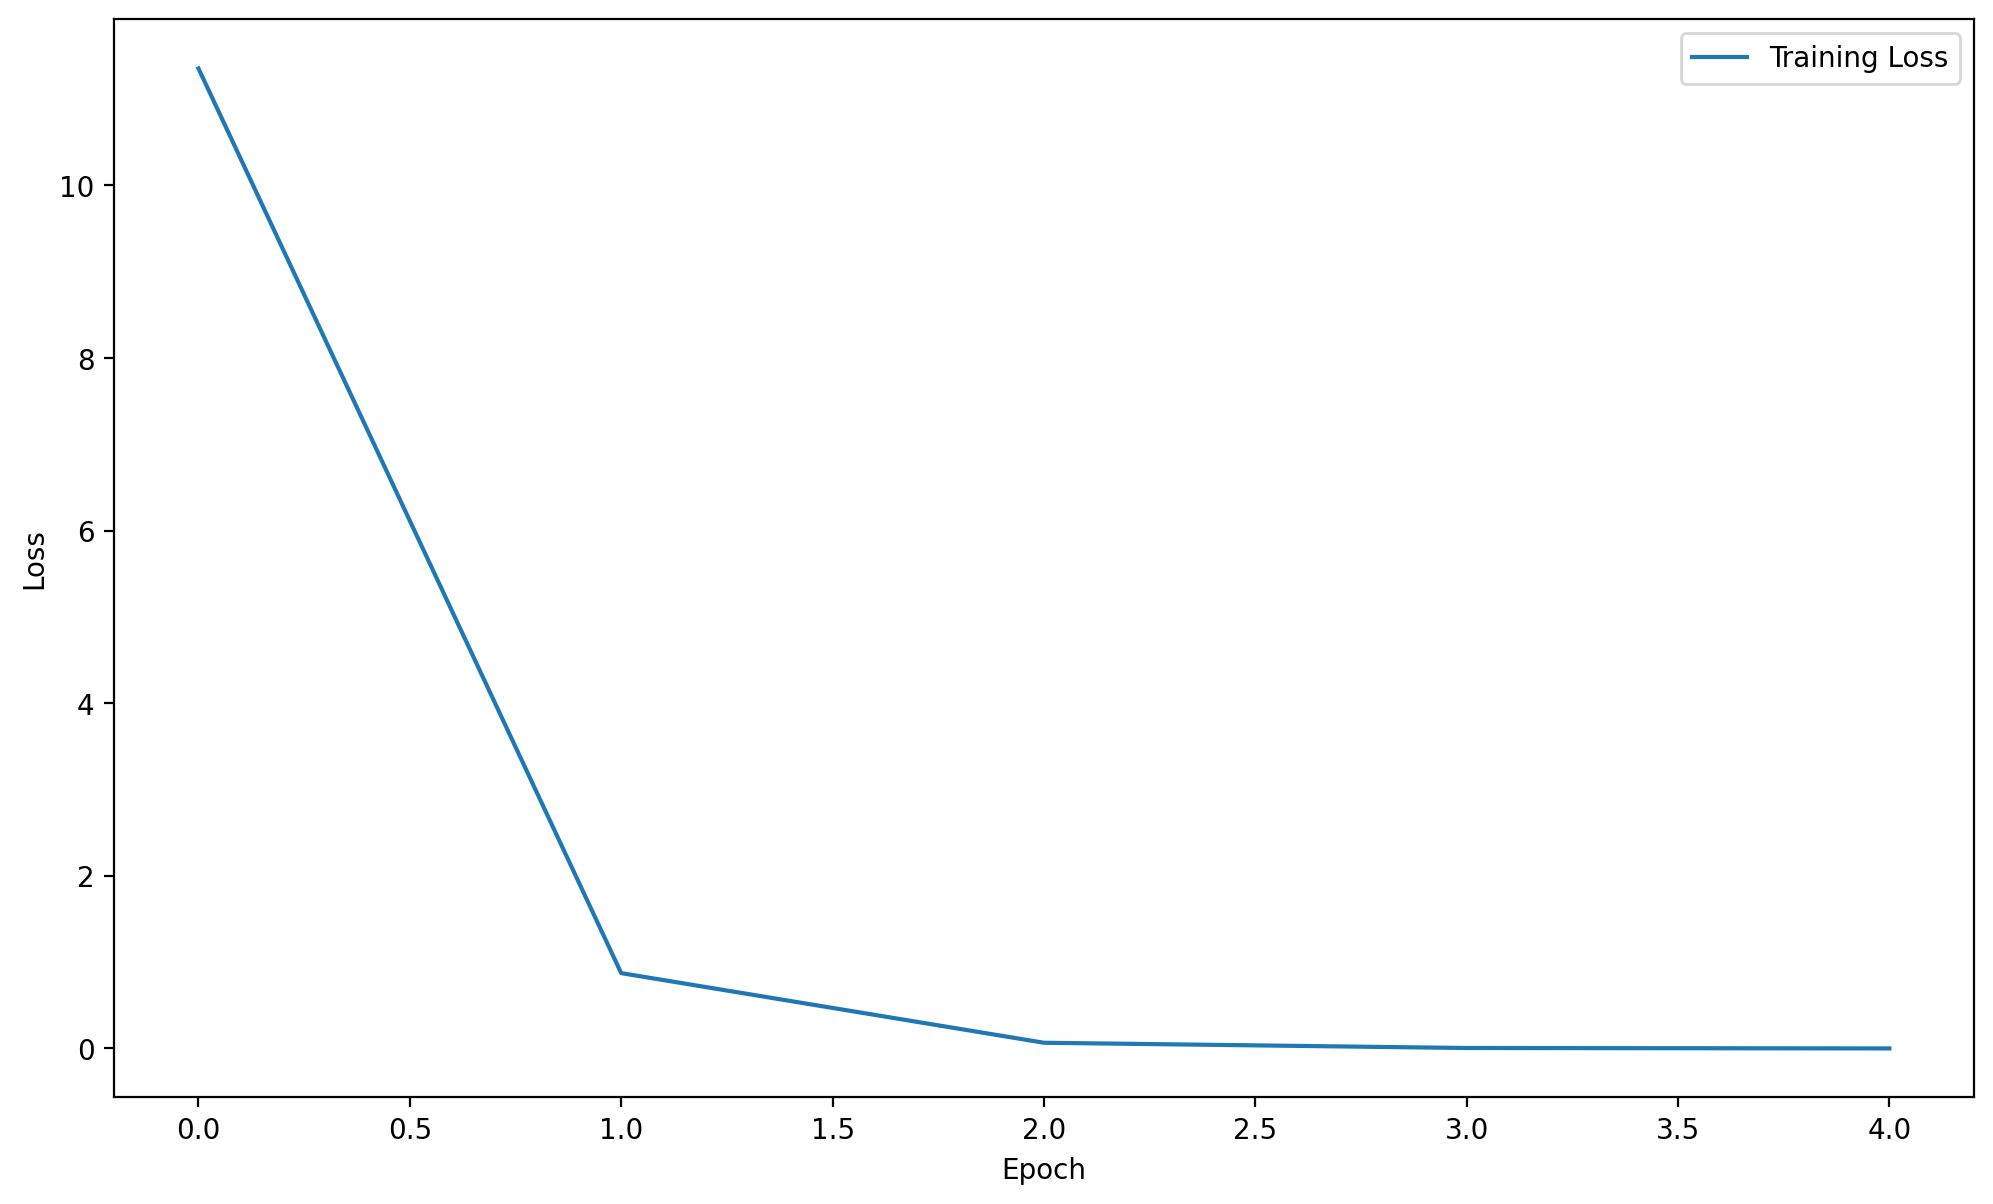

Final Values of parameters of the linear neural network
Parameter containing:
tensor([[ 1.9965, -3.3948]], requires_grad=True)
Parameter containing:
tensor([4.1928], requires_grad=True)
Target Values of the Parameters

target value of w: tensor([ 2.0000, -3.4000]) target value of b: 4.2


In [24]:

#####DEFINING PARAMETERS###########################
n = 2000  #Size of X
#True parameters to be used to generate the dataset
w1 = torch.tensor([2, -3.4])
b1 = 4.2
batch_size=32
###################################################
##Create dataset##
dataset = LinearRegressionDataset(n, w1, b1)
# This line creates a custom dataset class that generates linear regression data points.
# It takes parameters 'n' (number of data points), 'w1' (true weight vector), and 'b1' (true bias term).
###################################################
##Create dataloader**
dataloader = torch.utils.data.DataLoader(dataset, batch_size)
# This line creates a data loader that efficiently iterates over the dataset in batches.
# 'batch_size' specifies the number of data points processed together in each iteration.
###################################################
# Create model
model = LinearRegressionModel(len(w1))
# This line creates the linear regression model using the LinearRegressionModel class.
# It takes the length of the weight vector ('len(w1)') as input to define the model architecture.
###################################################
##Create loss function##
loss_fn = MSELossWrapper()
# This line creates an instance of the MSELossWrapper class. This class encapsulates the
# PyTorch mean squared error loss function ('nn.MSELoss') and provides a simplified interface.
###################################################
##Create optimizer##
optimizer = SGDOptimizer(model.parameters())
# This line creates an instance of the SGDOptimizer class. This class encapsulates the
# PyTorch SGD optimizer ('torch.optim.SGD') and provides a simplified interface for updating
# the model parameters during training. It takes the model parameters retrieved by 'model.parameters()' as input.
###################################################
##Training loop##
total_loss = []
for epoch in range(max_epochs):
  loss_value = 0.0
  for batch_idx, (batchX, batchy) in enumerate(dataloader):
    optimizer.zero_grad()
    # Clear the gradients accumulated from the previous iteration

    y_hat = model(batchX)
    # Perform the forward pass of the model on the current batch (batchX) to get predictions (y_hat)

    loss = loss_fn(y_hat, batchy)
    # Calculate the loss between the predictions (y_hat) and the true targets (batchy) using the loss function

    loss.backward()
    # Backpropagate the loss to calculate gradients with respect to the model parameters

    optimizer.step()
    # Update the model parameters based on the calculated gradients and the learning rate

    loss_value += loss.item()
  epoch_loss = loss_value / len(dataloader)
  total_loss.append(epoch_loss)

###################################################
##Plotting Error**
# we plot now the graph of total_loss values against the epochs.
plt.plot(total_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
###################################################
##Print final parameters$$
print("Final Values of parameters of the linear neural network")
for parameter in model.parameters():
  print(parameter)
#We compare tis to the target values of the parameters.
print("Target Values of the Parameters\n")
print("target value of w:", w1, "target value of b:", b1)
# Print the final learned values of the model parameters (weights and bias) and compare them 
# to the target values (w1 and b1) used for generating the data.

**QUESTION 9**

We might ask which number of epochs (`max-epochs`) is the "optimal" for our training, in the sense of being the minimal number that obtains a meaningful approximation.

Typically, you want to balance between underfitting (too few epochs) and overfitting (too many epochs). The best epoch number is usually just before the loss starts to plateau or increase due to overfitting.

Please run the training with the number of epochs from 4 to 10 and plot the final errors. Can you guess from that plot what is an optimal epoch number?

Epoch loss:  13.934555628943064
Epoch loss:  1.059441620395297


Epoch loss:  0.08222721017424077
Epoch loss:  0.006242701999976167


Epoch loss:  0.0006409213367280447


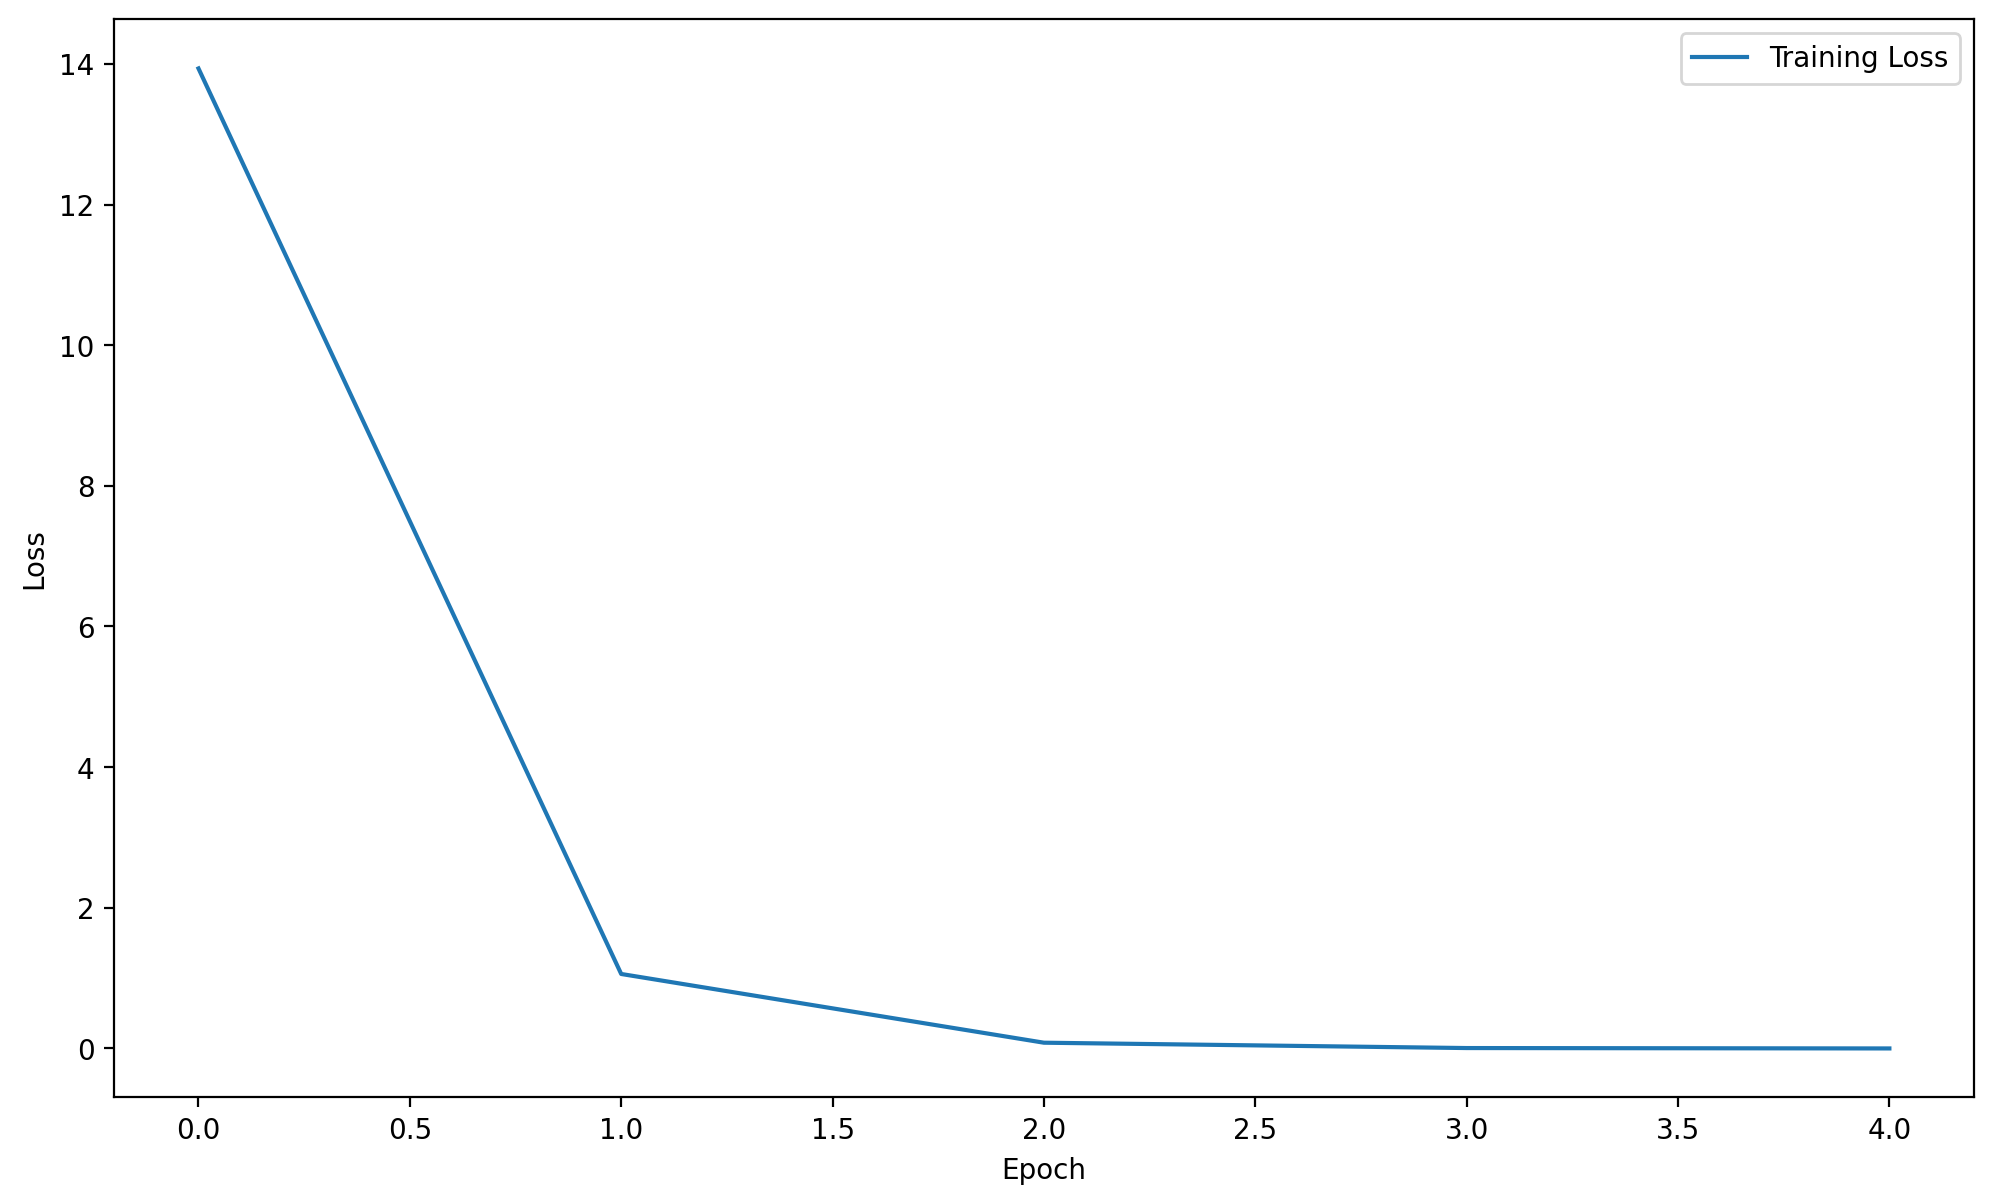

Final Values of parameters of the linear neural network
Parameter containing:
tensor([[ 1.9968, -3.3931]], requires_grad=True)
Parameter containing:
tensor([4.1915], requires_grad=True)
Target Values of the Parameters

target value of w: tensor([ 2.0000, -3.4000]) target value of b: 4.2


In [25]:
#Write your code here

#####DEFINING PARAMETERS###########################
n = 2000  #Size of X
#True parameters to be used to generate the dataset
w1 = torch.tensor([2, -3.4])
b1 = 4.2
batch_size=32
###################################################
##Create dataset##
dataset = LinearRegressionDataset(n, w1, b1)
# This line creates a custom dataset class that generates linear regression data points.
# It takes parameters 'n' (number of data points), 'w1' (true weight vector), and 'b1' (true bias term).
###################################################
##Create dataloader**
dataloader = torch.utils.data.DataLoader(dataset, batch_size)
# This line creates a data loader that efficiently iterates over the dataset in batches.
# 'batch_size' specifies the number of data points processed together in each iteration.
###################################################
# Create model
model = LinearRegressionModel(len(w1))
# This line creates the linear regression model using the LinearRegressionModel class.
# It takes the length of the weight vector ('len(w1)') as input to define the model architecture.
###################################################
##Create loss function##
loss_fn = MSELossWrapper()
# This line creates an instance of the MSELossWrapper class. This class encapsulates the
# PyTorch mean squared error loss function ('nn.MSELoss') and provides a simplified interface.
###################################################
##Create optimizer##
optimizer = SGDOptimizer(model.parameters())
# This line creates an instance of the SGDOptimizer class. This class encapsulates the
# PyTorch SGD optimizer ('torch.optim.SGD') and provides a simplified interface for updating
# the model parameters during training. It takes the model parameters retrieved by 'model.parameters()' as input.
###################################################
##Training loop##
total_loss = []
for epoch in range(max_epochs):
  loss_value = 0.0
  for batch_idx, (batchX, batchy) in enumerate(dataloader):
    optimizer.zero_grad()
    # Clear the gradients accumulated from the previous iteration

    y_hat = model(batchX)
    # Perform the forward pass of the model on the current batch (batchX) to get predictions (y_hat)

    loss = loss_fn(y_hat, batchy)
    # Calculate the loss between the predictions (y_hat) and the true targets (batchy) using the loss function

    loss.backward()
    # Backpropagate the loss to calculate gradients with respect to the model parameters

    optimizer.step()
    # Update the model parameters based on the calculated gradients and the learning rate

    loss_value += loss.item()
  epoch_loss = loss_value / len(dataloader)
  print("Epoch loss: ",epoch_loss)
  total_loss.append(epoch_loss)

###################################################
##Plotting Error**
# we plot now the graph of total_loss values against the epochs.
plt.plot(total_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
###################################################
##Print final parameters$$
print("Final Values of parameters of the linear neural network")
for parameter in model.parameters():
  print(parameter)
#We compare tis to the target values of the parameters.
print("Target Values of the Parameters\n")
print("target value of w:", w1, "target value of b:", b1)
# Print the final learned values of the model parameters (weights and bias) and compare them 
# to the target values (w1 and b1) used for generating the data.

The optimal epochs is 1 there are greatly diminishing returns after that.


**END OF WORKSHEET**

Make sure that you answered all the questions on time. This completed `Jupyter Notebook` will be collected and graded. 

Once the `Jupyter Notebook` is collected it can not be modified.